### Objective

In this notebook, we implement the **Neural ODE** approach to identify the unknown parameter in the governing ODE of the population growth dynamical system.

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk", font_scale=0.7)

import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(42)

from scipy.integrate import solve_ivp
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

### 1. Target Dynamical System: Logistic Growth Model

In this notebook, the specific dynamical system we are investigating is known as [logistic growth system](https://services.math.duke.edu/education/ccp/materials/diffeq/logistic/logi1.html):

\begin{equation}
\frac{dp(t)}{dt} = rp(t)(1-\frac{p(t)}{k}) - min(h \cdot p, H_{max}).
\end{equation}

Here, $p(t)$ denotes the population size at time $t$, $r$ and $k$ represent the intrinsic growth rate of the population and carrying capacity of the environment, respectively. $min(h \cdot p, H_{max})$ depicts the harvesting function with $h$ being the harvesting rate and $H_max$ being the maximum harvesting capacity. 

In [2]:
def logistic_growth(t, p, r, k, h, H_max):
    """
    ODE for logistic growth model.
    
    Inputs:
    -------
    t: time
    p: population size
    r: intrinsic growth rate
    k: carrying capacity
    h: harvesting rate
    H_max: maximum harvesting capacity
    
    Output:
    -------
    dpdt: Change rate of population size.
    """
    
    dpdt = r*p*(1-p/k) - min(h*p, H_max)
    
    return dpdt

### 2. Case Study: Parameter Estimation

In this section, we tackle our target case study, i.e., parameter estimation. 

More specifically, we assume $r$ is unknown and we aim to infer its value from the observational data.

#### 2.1 Strategy

To solve this problem, we can encapsulate the calculation of the popluation change rate (i.e., the right-hand side of the ODE) as a custom neural network layer and set the parameter $r$ as a trainable parameter of the layer. In this way, by training the neural network model (i.e., minimizing the loss between the model prediction and the observations), we are able to identify the correct value of $r$ that best fits the observational data. The benefit of this strategy is that it allows us to easily leverage the powerful gradient-based optimizers provided by the popular neural network frameworks (e.g., TensorFlow), and streamline the data organization for train/validation/test procedures.

#### 2.2 Data Generation

To begin with, let's generate the observation data required for training the Neural ODE model. Toward that end, we employ the scipy ODE solver to simulate the corresponding dynamical system for a given timespan. This obtained time trace will serve as our training dataset.

Note that here the ODE model with the true $r$ value is used only for creating the observation data. Later, we will assume that we do not know the $r$ value, and instead inferring it based on the observation data.

In [3]:
# Set parameters
r, k, h, H_max = 0.1, 1000, 0.01, 5

# Initial condition
p_0 = 20 

# Simulation time span
t_span = (0, 100)  
t_eval = np.linspace(t_span[0], t_span[1], 1000) 

# Solve ODE
solution = solve_ivp(logistic_growth, t_span, [p_0], 
                     t_eval=t_eval, args=(r, k, h, H_max))

Here, we visualize the general trend of the population evolution given the set ODE parameters.

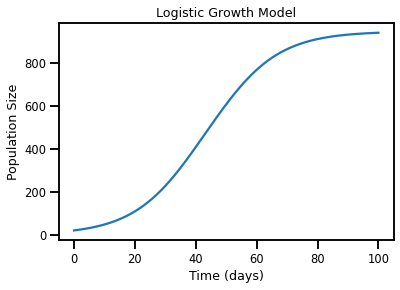

In [4]:
plt.plot(solution.t, solution.y[0])
plt.xlabel('Time (days)')
plt.ylabel('Population Size')
plt.title('Logistic Growth Model')
plt.show()

#### 2.3 Data organization

In [5]:
def create_windows(p_series, t_series, seq_length, overlap_length):
    """
    Create windows from the given time series data. 
    Overlapping is introduced to ensure context continuity.
    
    Inputs:
    -------
    p_series: time series of observed population size
    t_series: observed time
    seq_length: intrinsic growth rate
    overlap_length: carrying capacity
    
    Output:
    -------
    p_windows: segmented window array of population size
    t_windows: segmented window array of the time
    """
    
    p_windows, t_windows = [], []

    step_size = seq_length - overlap_length
    beg_index = 0

    while (end_idx := beg_index + seq_length) <= len(p_series):
        
        # Construct P array
        p_windows.append(p_series[beg_index:end_idx])
        
        # Calculate time intervals
        time_intervals = t_series[beg_index:end_idx] - t_series[beg_index]
        t_windows.append(time_intervals)
        
        beg_index += step_size

    return np.array(p_windows), np.array(t_windows)

In [6]:
# Compile dataset
p_windows, t_windows = create_windows(solution.y[0][:, np.newaxis], t_eval, seq_length=20, overlap_length=10)
print(f"p_windows array dimension: {p_windows.shape}")

p_windows array dimension: (99, 20, 1)


In [7]:
# Create TensorFlow Dataset
p_windows = p_windows.astype('float32')
t_windows = t_windows.astype('float32')

batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((p_windows, t_windows))

We split the entire dataset into a train set and a validation set. This validation set can be used to monitor the learning progress of the model and facilitate learning rate scheduling. 

Toward that end, we can randomly shuffle the dataset first and then select the first 80% for training and the remianing 20% for validation. It is worth mentioning that this way of splitting the dataset actually does not violate the temporal order: the shuffling operation only acts on the first dimension of `p_windows`, i.e., it rearranges these windows as complete units. Since each window still preserves its original temporal sequence, the overall temporal consistency of the data is not violated.

In [8]:
# Train/validation split
split_ratio = 0.8
train_num = int(split_ratio*len(p_windows))

# Split the dataset
dataset = dataset.shuffle(buffer_size=100000)
train_dataset = dataset.take(train_num)
val_dataset = dataset.skip(train_num)

# Batch the train & val datasets
train_dataset = train_dataset.batch(batch_size).shuffle(buffer_size=100000)
val_dataset = val_dataset.batch(batch_size)

### 3. Neural ODE Solution

#### 3.1 Define the custom layer

In [9]:
class PopulationChangeLayer(tf.keras.layers.Layer):
    def __init__(self, r_init, k, h, H_max, **kwargs):
        """
        Constructor for the custom layer for computing the population change rate.

        Inputs:
        -------
        r_init: initial value of intrinsic growth rate
        k_init: initial value of carrying capacity
        h: harvesting rate
        H_max: maximum harvesting capacity
        """  
        super(PopulationChangeLayer, self).__init__(**kwargs)
        self.r_init = r_init
        self.k = k
        self.h = h
        self.H_max = H_max
        
        
    def build(self, input_shape):
        self.r = self.add_weight(name='r', shape=(), 
                                 initializer=tf.keras.initializers.Constant(self.r_init), 
                                 trainable=True)


    def call(self, p, *args, **kwargs):
        """
        This layer computes the population change rate based on the given ODE.

        Inputs:
        -------
        inputs: population size
        """  
        
        # The governing ODE
        dp_dt = self.r*p*(1-p/self.k) - tf.minimum(self.h*p, self.H_max)
        
        return dp_dt

In [10]:
def define_model(input_dim, init_r, k, init_lr, h, H_max):
    """
    Construct the model for parameter estimation.
    
    Inputs:
    -------
    input_dim: input dimension
    init_r: initial value of intrinsic growth rate
    k: carrying capacity
    init_lr: initial learning rate
    h: harvesting rate
    H_max: maximum harvesting capacity
    
    Outputs:
    --------
    model: the compiled neural network model
    """    
    
    # Input layer
    input_layer = keras.layers.Input(shape=(input_dim,))
    
    # Total population change rate
    dp_dt = PopulationChangeLayer(init_r, k, h, H_max)(input_layer)
    
    # Compile model
    model = tf.keras.models.Model(inputs=input_layer, outputs=dp_dt)
    optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr)
    model.compile(optimizer=optimizer) 
    
    return model

#### 3.2 Define loss function

Here, we define a custom loss function to facilitate model training. Specifically, we implement the logic of multi-step ahead prediction to ensure the model's accuracy and robustness in predicting. 

In [11]:
@tf.function
def train_step(p_batch, t_batch, ode_nn):
    """Calculate loss and its gradients with respect to network model parameters.
    
    Inputs:
    ----
    p_batch: a batch of population evolution data, [batch_size, timesteps, feature_dim]
    t_batch: a batch of time evolution data, [batch_size, timesteps, feature_dim]
    ode_nn: neural ODE model 
    
    Outputs:
    --------
    ODE_loss: calculated ODE loss
    gradients: gradients of the ODE loss with respect to network model parameters.
    """
    
    with tf.GradientTape() as tape:
        batch_size, seq_length, _ = p_batch.shape
        loss = 0

        # Batch processing each step of the time series
        p = p_batch[:, 0]
        for i in range(seq_length - 1):
            
            # Calculate time step
            delta_t = t_batch[:, i+1] - t_batch[:, i]

            # Calculate the population change rate
            dp_dt = ode_nn(p)

            # Euler scheme  
            p = p + delta_t[:, tf.newaxis]*dp_dt

            # Sum loss for the whole batch (for the current time step)
            loss += tf.reduce_mean(tf.square(p - p_batch[:, i+1]))

        # Average the loss over all time steps
        loss /= (seq_length - 1)

    # Compute gradients
    gradients = tape.gradient(loss, ode_nn.trainable_variables)

    return loss, gradients

In [12]:
def val_step(p_batch, t_batch, ode_nn):
    """Calculate validation loss.
    
    Inputs:
    ----
    p_batch: a batch of population evolution data, [batch_size, timesteps, feature_dim]
    t_batch: a batch of time evolution data, [batch_size, timesteps, feature_dim]
    ode_nn: neural ODE model 
    
    Outputs:
    --------
    loss: calculated ODE loss
    """
    batch_size, seq_length, _ = p_batch.shape
    loss = 0

    # Batch processing each step of the time series
    p = p_batch[:, 0]
    for i in range(seq_length - 1):

        # Calculate time step
        delta_t = t_batch[:, i+1] - t_batch[:, i]

        # Calculate the population change rate
        dp_dt = ode_nn(p)

        # Euler scheme  
        p = p + delta_t[:, tf.newaxis]*dp_dt

        # Sum loss for the whole batch (for the current time step)
        loss += tf.reduce_mean(tf.square(p - p_batch[:, i+1]))

    # Average the loss over all time steps
    loss /= (seq_length - 1)

    return loss

#### 3.3 Training logic



In [19]:
# Setup NN hyperparameters
input_dim = 1

# Instantiate NN
init_r = 0.3
ode_nn = define_model(input_dim, init_r, k=k, init_lr=2e-3, h=h, H_max=H_max)

# Training Loop
num_epochs = 100
train_loss_hist, val_loss_hist, r_list = [], [], []

with tf.device("CPU:0"):
    
    # Configure learning rate scheduler
    ode_nn_callbacks = tf.keras.callbacks.CallbackList(
                      [keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=50)], 
                        add_history=False, model=ode_nn)

    for epoch in range(num_epochs):
        
        # Initialize epoch-wise losses
        train_total_loss, val_total_loss = 0, 0

        # Training
        for p_batch, t_batch in train_dataset:
            
            # Calculate loss & gradients
            train_loss, gradients = train_step(p_batch, t_batch, ode_nn)
            
            # Update parameters
            ode_nn.optimizer.apply_gradients(zip(gradients, ode_nn.trainable_variables))
            
            # Accumulate loss
            train_total_loss += train_loss

        # Normalize loss
        train_total_loss /= len(train_dataset)

        # Validation loop
        for p_batch, t_batch in val_dataset:
            val_loss = val_step(p_batch, t_batch, ode_nn)
            val_total_loss += val_loss

        # Normalize validation loss
        val_total_loss /= len(val_dataset)

        # Callbacks
        ode_nn_callbacks.on_epoch_end(epoch, logs={'val_loss': val_total_loss})

        # Logging
        print(f"Epoch {epoch+1}:")
        print(f"Train Loss: {train_total_loss.numpy():.3e}, Val Loss: {val_total_loss.numpy():.3e}")
        print(f"r: {ode_nn.layers[-1].r.numpy():.3}")

        train_loss_hist.append(train_total_loss)
        val_loss_hist.append(val_total_loss)
        r_list.append(ode_nn.layers[-1].r.numpy())
        
        # Reshuffle train dataset
        dataset = dataset.shuffle(buffer_size=100000)
        train_dataset = dataset.take(train_num).shuffle(buffer_size=100000).batch(batch_size)
        val_dataset = dataset.skip(train_num).batch(batch_size)

Epoch 1:
Train Loss: 1.129e+03, Val Loss: 6.242e+02
r: 0.294
Epoch 2:
Train Loss: 1.004e+03, Val Loss: 6.208e+02
r: 0.288
Epoch 3:
Train Loss: 9.624e+02, Val Loss: 8.415e+02
r: 0.282
Epoch 4:
Train Loss: 9.153e+02, Val Loss: 7.903e+02
r: 0.276
Epoch 5:
Train Loss: 8.685e+02, Val Loss: 7.637e+02
r: 0.271
Epoch 6:
Train Loss: 8.204e+02, Val Loss: 9.508e+02
r: 0.265
Epoch 7:
Train Loss: 6.823e+02, Val Loss: 5.230e+02
r: 0.259
Epoch 8:
Train Loss: 6.880e+02, Val Loss: 7.588e+02
r: 0.254
Epoch 9:
Train Loss: 6.541e+02, Val Loss: 3.746e+02
r: 0.248
Epoch 10:
Train Loss: 6.193e+02, Val Loss: 5.364e+02
r: 0.243
Epoch 11:
Train Loss: 6.012e+02, Val Loss: 6.289e+02
r: 0.237
Epoch 12:
Train Loss: 5.076e+02, Val Loss: 4.694e+02
r: 0.232
Epoch 13:
Train Loss: 5.129e+02, Val Loss: 4.353e+02
r: 0.226
Epoch 14:
Train Loss: 4.033e+02, Val Loss: 4.378e+02
r: 0.221
Epoch 15:
Train Loss: 4.127e+02, Val Loss: 4.958e+02
r: 0.216
Epoch 16:
Train Loss: 3.871e+02, Val Loss: 4.259e+02
r: 0.211
Epoch 17:
Train L

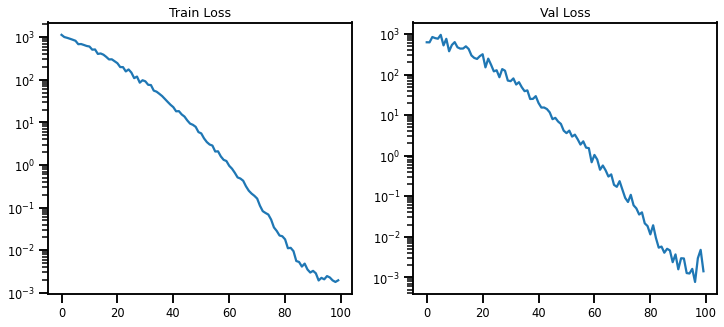

In [20]:
# History
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(range(num_epochs), train_loss_hist)
ax[1].plot(range(num_epochs), val_loss_hist)
ax[0].set_title('Train Loss')
ax[1].set_title('Val Loss')
for axs in ax:
    axs.set_yscale('log')

Text(0, 0.5, 'Estimated r value')

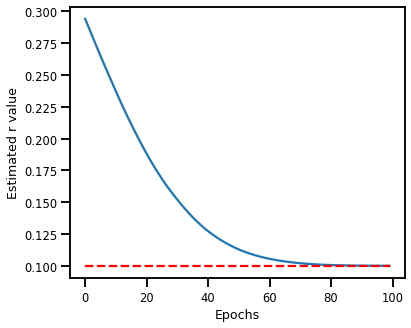

In [21]:
# Parameter estimation
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(range(num_epochs), r_list)
ax.plot(range(num_epochs), 0.1*np.ones(len(r_list)), 'r--')
ax.set_xlabel('Epochs')
ax.set_ylabel('Estimated r value')

\begin{equation}
y_{i+2} = y_{i+1} + \Delta t \cdot f(y_{i+1})
\end{equation}

\begin{equation}
\frac{dp}{dt} = \boldsymbol{r}p(1-\frac{p}{k}) - min(h \cdot p, H_{max}).
\end{equation}